<a href="https://colab.research.google.com/github/srinath2022/physics-based-DL/blob/master/toyexample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Toy Example

We will start off by considering a toy example of tossing a coin and eventually add air resistance etc. Let us begin by writing down the velocity and displacement equations of a point mass object thrown vertically above the ground with an initial velocity $u_0$.   

Under the effect of gravity, the velocity of the object at any time instant from start($t=0$) is given by   

$ v_t = u_0 + gt $   

where $g$ represents acceleration due to gravity $\sim 10 \frac{m}{s^2}$ 

Also, the displacement covered by the point mass is given by

$ s_t = u_0t + \frac{1}{2}gt^2 $

In [170]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear, Sigmoid, ReLU, Tanh, BatchNorm1d, ELU, LeakyReLU
import torch.optim as optim

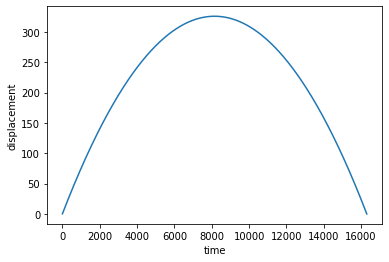

In [197]:
# Prediction of path using physics alone without any external variables
#inital velocity
u_int = 79.9
# acceleration due to gravity
a = -9.8
dt = 0.001
t = dt
vert_disp = []
v = u_int + a* dt
ds = (v**2 - u_int**2)/(2*a)
s = ds
vert_disp.append(s)
u_int = v
data_pair = []  
while( s > 0):
  v = u_int + a* dt
  ds = (v**2 - u_int**2)/(2*a)
  s+= ds
  t = t + dt
  vert_disp.append(s)
  u_int = v
  

# Plot the displacement
plt.plot(vert_disp)
plt.ylabel('displacement')
plt.xlabel('time')
plt.show()

In [198]:
## Generate Ground truth data using for toss experiment without any external variables
data =[]
for i in range(100):
  #random inital velocity
  u_int = np.random.rand(1)*100
  u_int = u_int[0]
  # acceleration due to gravity
  a = -9.8
  # random time steps for experiment between 0.01 to 0.001
  
  dt = [0.01]
  dt = dt[0]
  t = dt
  vert_disp = []
  v = u_int + a* dt
  ds = (v**2 - u_int**2)/(2*a)
  s = ds
  vert_disp.append(s)
  pair = [np.array([u_int, t]), np.array([s,v])]
  u = v
  data.append(np.array(pair)) 
  while( s > 0):
    v = u + a* dt
    ds = (v**2 - u**2)/(2*a)
    s+= ds
    t = t + dt
    vert_disp.append(s)
    pair = np.array([np.array([u_int, t]), np.array([s,v])])
    u = v
    data.append(pair)

data = np.array(data)


Let us try to learn trajectory of the ball using supervised learning. The input to our model is intial veclocity and timestamp which which return us the velocity at an instant and displacement in the air.

In [262]:
from torch.optim import optimizer

## Train a neural network with supervised learning

class PhysicsData(Dataset):
  def __init__(self, data):
    self.data = data
  def __len__(self):
    return self.data.shape[0]
  def __getitem__(self, index):
    return data[index][0], data[index][1]
num_samples = data.shape[0]
print(num_samples)
training_data = PhysicsData(data[:int(num_samples*0.8)])
test_data = PhysicsData(data[int(num_samples*0.8):])

train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

def physicsBasedLoss(u,t,s):
  return torch.sum(torch.abs(s - u*t + 0.5*9.8*t**2))

## MLP used for learining data
class NewtonNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.nn1 = Linear(in_features=2, out_features=16)
    self.nn2 = Linear(in_features=16, out_features=16)
    self.nn3 = Linear(in_features=16, out_features=2)
    self.relu = ReLU()
    self.sigmd = Sigmoid()
    self.tanh = Tanh()
    self.elu  = ELU()
    self.bn = BatchNorm1d(3)
    self.bn1 = BatchNorm1d(2)
    self.leaky = LeakyReLU()
  def forward(self, x):
    x = self.nn1(x)
    x = self.tanh(x)
    x = self.nn2(x)
    x = self.tanh(x)
    x = self.nn3(x)

    return x

device = torch.device("cuda:0" if torch.cuda.is_available() else  "cpu")
print(device)
epochs = 20
net = NewtonNet()
net.to(device=device)
net.train()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr = 0.005)

for epoch in range(epochs):
  epoch_running_loss = 0.0
  for i,batch in enumerate(train_dataloader):
    inp, op = batch
    inp = inp.to(device)
    op = op.to(device)
    predicted = net(inp.float())
    optimizer.zero_grad()
    loss = criterion(predicted, op.float())
    #loss = physicsBasedLoss(predicted[:,1],t, predicted[:,0])
    loss.backward()
    epoch_running_loss = epoch_running_loss+loss.detach().cpu()
    
    optimizer.step()
  print(f"{epoch+1}, epoch loss {epoch_running_loss/len(train_dataloader):.5f}")
print("Fininshed training ")


109447
cuda:0
1, epoch loss 7163.86279
2, epoch loss 311.41400
3, epoch loss 59.95062
4, epoch loss 38.90646
5, epoch loss 33.42656
6, epoch loss 37.26514
7, epoch loss 32.83432
8, epoch loss 29.73727
9, epoch loss 28.22831
10, epoch loss 35.53238
11, epoch loss 27.14314
12, epoch loss 28.72383
13, epoch loss 28.71417
14, epoch loss 26.81671
15, epoch loss 27.16022
16, epoch loss 28.70548
17, epoch loss 23.10895
18, epoch loss 25.93387
19, epoch loss 25.69674
20, epoch loss 25.02996
Fininshed training 


Inference: Given timestamps and initial velocity, let us predict the displacement and velocity at an instant of time.

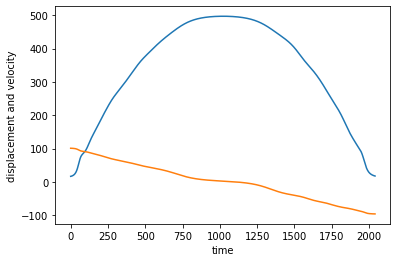

In [267]:

u_int = 100
vert_disp = []
dt = 0.01
t = dt
upper_time = 2*(u_int/9.8)
inps = []
inp = [u_int, t]
inps.append(inp)  
vert_disp = []
v = u_int + a* dt
ds = (v**2 - u_int**2)/(2*a)
s = ds
vert_disp.append(s)
u = v
while( t < upper_time):
  inp = [u_int, t]
  inps.append(inp)
  v = u + a* dt
  ds = (v**2 - u_int**2)/(2*a)
  s+= ds
  u = v
  t =t+dt
inps= torch.FloatTensor(inps)
inps = inps.to(device)
op  = net(inps)
op = op.cpu().data.numpy()
# op = list(zip(op, np.array(vert_disp)))
# print(op)
#x = np.linspace(1, t, 1/dt)
# Plot the displacement
plt.plot(op)
plt.ylabel('displacement and velocity')
plt.xlabel('time')
plt.show()